# INF8111 - Fouille de données 
## Été 2020 - TP3 - Fouille de réseaux sociaux
### Membres de l'équipe
    - Kacem Khaled
    - Oumayma Messoussi
    - Semah Aissaoui



## Directives de remise
Le travail sera réalisé avec la  même équipe que pour les TPs précédents. 
Vous devez remettre dans la boîte de remise sur moodle:

1. ce fichier nommé TP3\_NomDuMembre1\_NomDuMembre2\_NomDuMembre3.ipynb

**N.B**: Assurez-vous que tous les résultats sont lisibles lorsque le notebook est ouvert.

Tout devra être remis avant le **20 juin 2020 à 23h55**. Tout travail en retard sera pénalisé d’une valeur de 10\% par jour de retard.

## Barème
Partie 1: 12 points

Partie 2: 8 points

Pour un total de 20 points sur 20 points.


## Réseaux sociaux
Les réseaux sociaux occupent une grande partie de la vie humaine. Chaque personne appartient tout le long de sa vie à différentes communautés. Avec le rassemblage de ces informations sur les différentes plateformes en ligne de réseaux sociaux, les analystes de données ont voulu exploiter ces données. C'est un domaine relativement nouveau qui est en pleine croissance avec plusieurs impacts sur plusieurs aspects tels que la publicité et les systèmes de recommandation. 

### But
Le but de ce TP est de vous donner un aperçu de l'analyse d'un réseau social.

Dans la première partie, vous implémenterez un algorithme de détection de communautés dans un réseau social nommé LPAm+. Cet algorithme a été proposé par [X. Liu et T. Murata en 2010](https://www.sciencedirect.com/science/article/pii/S0378437109010152).

Dans la deuxième partie, vous trouverez les personnes avec le plus d'influence dans leur réseau social. 

Pour les deux parties, nous vous fournissons les csv contenant les réseaux sociaux à analyser.


# 1. LPAm+ (12 points)

## Détection de communauté
La détection de communauté dans un réseau social est une manipulation fréquente lors de l'analyse d'un réseau. Une méthode de clustering est utilisée pour rassembler les personnes dans des communautés selon les liens entre eux. 

## LPAm+
Dans cette partie, vous implémenterez l'algorithme LPAm+ pour détecter les communautés parmi les personnages de Games of Thrones. Vous devez utiliser les csv de nodes et de edges pour cela. 

Cet algorithme consiste à propager les étiquettes dans le réseau selon une règle d'évaluation optimisant la modularité du réseau. Lorsque l'algorithme atteint un optimum local, il regarde s'il peut combiner deux communautés pour augmenter la modularité du réseau. L'algorithme choisit toujours la combinaison la plus avantageuse. Si une combinaison est trouvée, la propagation des étiquettes est refaite. L'algorithme continue tant qu'elle peut améliorer la modularité. Vous pouvez lire l'article mentionné plus haut pour plus de détails, mais cela n'est pas nécessaire puisque vous allez être guidé tout le long du TP. 

Pour faciliter la représentation du réseau, nous vous proposons d'utiliser le package networkx. Vous pouvez lire plus sur le package [ici](https://networkx.github.io/documentation/stable/tutorial.html).

In [1]:
# vous pouvez bien sûr utiliser anaconda pour installer les packages
!pip install --user numpy
!pip install --user pandas
!pip install --user matplotlib
!pip install --user networkx

In [121]:
import numpy as np
import networkx as nx
import random
import itertools
import math
import copy
from itertools import combinations


class LPAmPlus:
    """
    Contructeur
    """

    def __init__(self, graph):
        """
        graph donne le graph sur lequel l'algoritme va être appliqué;
        """
        self.graph = graph

        """
        labels donne l'ensemble des communautés présentes dans le réseau
        """
        self.labels = []

        """
        Assigner une étiquette à chaque sommet
        """
        for l,n in enumerate(list(self.graph.nodes)):
            self.graph.nodes[n]['label']=l
            self.labels.append(l)

    """
    Terme à optimiser lors du remplacement des étiquettes
    """
    def label_evaluation(self, current_node, new_label):
        # Index current node
        index_current_node=list(self.graph.nodes).index(current_node)
        # Compute the modularity matrix 
        B = nx.modularity_matrix(self.graph)
        # Compute n:nombre de noeuds
        n=self.graph.number_of_nodes()
        lmax=0
        for u in range(n):
            if index_current_node == u:
                continue
            lmax+=B[u,index_current_node]*int(self.graph.nodes[u]['label']==new_label)
        return lmax


    """
    Fonction pour le remplacement d'étiquette
    """


    def update_label(self, current_node):
        node_label={}
        for label in self.labels:
            node_label.setdefault(label,self.label_evaluation(current_node,label))
        max_label=max(node_label,key=node_label.get)
        self.graph.nodes[current_node]['label']= max_label
            

    """
    Fonction qui calcule la modularité actuelle du réseau
    """

    def modularity(self):
        # Compute the modularity matrix 
        B = nx.modularity_matrix(self.graph)
        # Compute m
        m=self.graph.number_of_edges()
        # Compute n
        n=self.graph.number_of_nodes()
        Q=0
        for u in range(n):
            for v in range(n):
                if self.graph.nodes[u]==self.graph.nodes[v]:
                    Q=Q+B[u,v]
        Q=Q/(2*m)
        return Q
    
    
    """
    Fonction qui applique l'algorithme LPAm sur le réseau
    """

    def LPAm(self):
        Community_number=5
        i=0
        while(i<Community_number):
            for n in self.graph.nodes:
                # Compute modularity
                mod=self.modularity()
                # copy the graph
                aux_graph=copy.deepcopy(self.graph)
                # Update label node
                self.update_label(n)
                self.labels=list(dict.fromkeys(list(nx.get_node_attributes(self.graph, 'label').values())))
                if self.modularity()==mod:
                    i+=1
                elif self.modularity()<mod:
                    self.graph=aux_graph
                    self.labels=list(dict.fromkeys(list(nx.get_node_attributes(self.graph, 'label').values())))
                    return 
                else:
                    i=0
                
   
    """
    Fonction qui trouve les deux communautés à combiner et les combine
    """
    def merge_communities(self):
        init_mod=self.modularity()
        # Possible label_combinations
        label_combinations=list(combinations(self.labels, 2))
        aux_graph=copy.deepcopy(self.graph)
        aux_labels=copy.deepcopy(self.labels)
        comb_dic={}
        for c in label_combinations:
            self.labels.remove(c[1])
            list_label_node=[node for node in self.graph.node if self.graph.nodes[node]['label']==c[1]]
            for node in list_label_node:
                self.graph.nodes[node]['label']=c[0]
            comb_dic.setdefault(c,self.modularity())
            self.graph=copy.deepcopy(aux_graph)
            self.labels=copy.deepcopy(aux_labels)
        # Best combination that gives best modularity value
        best_combination_mod=max(comb_dic,key=comb_dic.get)
        if comb_dic[best_combination_mod]>init_mod:
            self.labels.remove(best_combination_mod[1])
            list_label_node=[node for node in self.graph.node if self.graph.nodes[node]['label']==best_combination_mod[1]]
            for n in list_label_node:
                self.graph.nodes[n]['label']=best_combination_mod[0]
            return True
            
        else:
            return False
    
    
    """
    Fonction qui applique LPAm+ sur le réseau
    """

    def find_communities(self):
        self.LPAm()
        while(self.merge_communities()):
             self.LPAm()
    
    

### 1.1 Dataset (1 point)

Nous vous avons fourni les csv pour toutes les saisons de Games of Thrones. Vous devez maintenant représenter ces réseaux en code en utilisant les deux csv fournis pour chaque saison: un pour les sommets et un pour les arêtes. 


#### Implémentation
1. Implémentez  la fonction  *`load_unweighted_network`*. Cette fonction retourne le réseau non dirigé et sans poids.

Utilisez la fonction `test_load` pour vérifier votre implémentation de la fonction. Ce test utilise un petit toy dataset. Vous devriez avoir quelque chose de similaire:
![title](data/picture.png)

In [124]:
import matplotlib.pyplot as plt
import csv
import pandas as pd
import networkx as nx
df_nodes=pd.read_csv('data/got-s1-nodes.csv')
df_nodes.head()
df_edges=pd.read_csv('data/got-s1-edges.csv')
df_edges.head()

,Source,Target,Weight,Season
0,NED,ROBERT,192,1
1,DAENERYS,JORAH,154,1
2,JON,SAM,121,1
3,LITTLEFINGER,NED,107,1
4,NED,VARYS,96,1


In [125]:
import csv
import pandas as pd
import networkx as nx


def load_unweighted_network(node_csv, edge_csv):
    df_nodes=pd.read_csv(node_csv)
    df_edges=pd.read_csv(edge_csv)
    G=nx.Graph()
    G.add_nodes_from(df_nodes.Id)
    G.add_edges_from(zip(df_edges.Source, df_edges.Target))
#     G = nx.from_pandas_edgelist(df_edges, 'Source', 'Target')

    return G

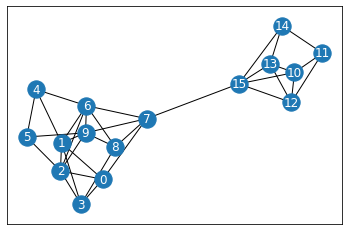

In [126]:
import matplotlib.pyplot as plt
def test_load():
    network = load_unweighted_network("data/toy-nodes.csv", "data/toy-edges.csv")
    nx.draw_networkx(network,font_color='white')
    plt.show()

test_load()

### 1.2  Modularité (1 point)

La modularité $Q$ du réseau est une mesure importante pour l'algorithme. Elle permet de savoir si l'algorithme a atteint un optimum local ou pas. $$ Q=\frac{1}{2m}\sum_{u,v=1}^n B_{uv}\delta(l_u,l_v)$$ 

- m: le nombre d'arêtes
- l: l'étiquette du sommet
- u, v: des sommets dans le réseau
- B: la matrice de modularité où chaque élément vaut $A_{uv} - P_{uv}$
- $A_{uv}$: vaut 1 si il y une arête entre u et v sinon 0
- $P_{uv}$: la probabilité qu'il y ait une arête entre u et v selon le modèle nul  $$P_{uv}=\frac{degree(u)*degree(v)}{2m}$$
- $\delta(l_u,l_v)$: delta de Kronecker, vaut 1 si les deux labels sont identiques sinon 0

Elle peut aussi être définie comme: $$Q=\sum_{t=1}^{N_c}\left(\frac{I_t}{m}-\left(\frac{D_t}{2m}\right)^2\right)$$

- m: le nombre d'arêtes
- Nc: le nombre de communautés
- t: une communauté dans le réseau
- $I_t$: le nombre d'arêtes dans la communauté t c'est-à-dire que les deux sommets de l'arête appartiennent à t
- $D_t$: la somme des degrés de tous les sommets appartenant à t

#### Implémentation
1. Implémentez  la fonction  `modularity`  dans LPAmPlus. Cette fonction retourne la modularité du réseau. Vous pouvez utiliser la fonction `linalg.modularity_matrix` de networkx pour calculer la matrice B. Prenez la définition présentée que vous voulez. **N.B:** Networkx permet d'ajouter du data sur les sommets pour garder des informations sur le node.

Utilisez la fonction `test_modularity` pour vérifier votre implémentation de la fonction. Vous devriez obtenir une modularité d'environ 0.413.

In [127]:
def test_modularity():
    social_network = load_unweighted_network("data/toy-nodes.csv", "data/toy-edges.csv")
    lpam = LPAmPlus(social_network)
    lpam.labels = [0, 1]
    for i in [0,1,2,3,4,5,6,7,8,9]:
        lpam.graph.nodes[i]['label'] = 0
    for i in [10,11,12,13,14,15]:
        lpam.graph.nodes[i]['label'] = 1
    print("Modularity: {}".format(lpam.modularity()))
    print("Communities :",list(dict.fromkeys(list(nx.get_node_attributes(social_network, 'label').values()))))
test_modularity()

Modularity: 0.41265306122448997
Communities : [0, 1]


### 1.3 Règle de modification des étiquettes (2 points)

Comme mentionné plus haut, l'algorithme est fortement basé sur son optimisation de la modularité. Il vous est maintenant demandé d'implémenter le terme à optimiser. La nouvelle étiquette $l_x^{new}$ correspond à l'étiquette pour laquelle la somme donne la plus grande valeur.
$$l_x^{new}=\arg\max\sum_{u=1}^n B_{ux}\delta(l_u,l)$$

- n: le nombre de sommets
- m: le nombre d'arêtes
- l: l'étiquette du sommet
- x: le sommet qu'on évalue en ce moment
- u: un autre sommet dans le réseau (commence à 1, car on exclut le sommet x)
- B: la matrice de modularité où chaque élément vaut $A_{ux} - P_{ux}$
- $A_{ux}$: vaut 1 si il y une arête entre u et x sinon 0
- $P_{ux}$: la probabilité qu'il y ait une arête entre u et x selon le modèle nul  $$P_{ux}=\frac{degree(u)*degree(x)}{2m}$$
- $\delta(l_u,l)$: delta de Kronecker, vaut 1 si les deux labels sont identiques sinon 0


#### Implémentation
1. Implémenter la fonction `label_evaluation`. Cette fonction retourne la valeur du terme à optimiser. Vous pouvez utiliser la fonction `linalg.modularity_matrix` de networkx pour calculer la matrice B. Il est normal qu'il y ait une ressemblance avec le calcul de la modularité selon la définition que vous avez prise.
2. Implémenter la fonction `update_label`. Cette fonction choisit la nouvelle étiquette pour le sommet actuel. En cas d'égalité, la fonction choisit une étiquette au hasard parmi les meilleurs. N'oubliez pas d'enlever les étiquettes désuètes du paramètre `labels`. **N.B:** Networkx permet d'ajouter du data sur les sommets pour garder des informations sur le node.


### 1.4 LPAm (3 points)

Vous pouvez maintenant implémenter l'algorithme LPAm. Cet algorithme est le prédécesseur de LPAm+. Il commence par donner une étiquette unique à chaque sommet. Il explore par la suite tous les sommets et change leur étiquette selon la fonction d'évaluation que vous avez implémentée plus tôt. L'algorithme continue jusqu'il ne puisse plus améliorer la modularité du réseau.

#### Implémentation
1. Initialiser correctement le paramètre `labels` de LPAmPlus et ajouter les étiquettes aux sommets du graphe dans la fonction `__init__`.

2. Implémenter l'algorithme LPAm dans la fonction `LPAm`. Assurez-vous de toujours augmenter la modularité lors de vos changements d'étiquettes.

Utilisez la fonction `test_lpam` pour vérifier votre implémentation. Vous devriez finir avec une modularité d'environ 0.399 avec 4 communautés.

In [128]:
def test_lpam():
    social_network = load_unweighted_network("data/toy-nodes.csv", "data/toy-edges.csv")
    lpam = LPAmPlus(social_network)
    lpam.LPAm()
    print("Modularity: {}\nCommunities: {}".format(lpam.modularity(), lpam.labels))

test_lpam()

Modularity: 0.39877551020408175
Communities: [3, 5, 8, 11]


### 1.5 LPAm+ (2 point)

Vous pouvez maintenant implémenter LPAm+ au complet. Lorsque LPAm tombe dans un optimum local, LPAm+ essaye de combiner deux communautés pour augmenter la modularité. LPAm+ choisit la combinaison qui augmente le plus la modularité et recommence la propagation d'étiquette jusqu'au prochain optimum local. L'algorithme continue jusqu'à qu'il ne peut plus augmenter la modularité.

#### Implémentation
1. Implémentez  la fonction  `merge_communities`. Cette fonction regarde si combiner des communautés augmente la modularité et combine les meilleurs choix. Elle retourne True si une combinaison a été faite sinon False.
2. Implémenter `find_communities`. Cette fonction applique l'algorithme LPAm+ sur le réseau.

Utilisez la fonction `test_lpam_plus` pour vérifier votre implémentation. Vous devriez finir avec une modularité d'environ 0.413 et 2 communautés.

In [129]:
def test_lpam_plus():
    social_network = load_unweighted_network("data/toy-nodes.csv", "data/toy-edges.csv")
    lpam = LPAmPlus(social_network)
    lpam.find_communities()
    print("Modularity: {}\nCommunities: {}".format(lpam.modularity(), lpam.labels))

test_lpam_plus()

Modularity: 0.41265306122448997
Communities: [3, 11]


### 1.6 GOT dataset (4 points)

Rouler votre algorithme sur les données de Games of Thrones de chaque saison et comparer ce que vous obtenez et les vraies communautés. 

Commencez par calculer le ARI (ajusted Rand index) de vos résultats. $$ ARI=\frac{TP+TN}{TP+TN+FN+TN} = \frac{TP+TN}{\binom{n}{2}}$$

- n: le nombre de sommets
- TP: True positive soit le nombre de paires d'éléments qui se trouvent dans la même communauté dans vos résultats et dans le ground truth
- TN: True négative soit le nombre de paires d'éléments qui se trouvent dans des communautés différentes dans vos résultats et dans le ground truth
- FP: False positive soit le nombre de paires d'éléments qui se trouvent dans la même communauté dans vos résultats mais qui sont dans des communautés différentes dans le ground truth
- FN: False négative soit le nombre de paires d'éléments qui se trouvent dans des communautés différentes alors qu'ils sont dans la même communauté dans le ground truth


L'algorithme performe-t-il bien sur toutes les saisons ou pour certaines seulement? Expliquer pourquoi vous avez obtenu ces résultats. Vous pouvez faire les manipulations que vous voulez pour mieux présenter vos résultats et mieux appuyer vos affirmations. 

### Résultats

In [ ]:
# Mettez votre code ici


### Analyse
Écrivez votre analyse ici

# 2. Personnages influents dans GOT (8 points)

##  Analyse d'un réseau social 
Une autre analyse intéressante à faire avec un réseau social est de trouver les personnes influentes du réseau soit les personnes autour desquelles les gens du réseau se regroupent.

Il existe des mesures qui permettent de connaître ces personnes: les mesures de centralité. Pour vous aider lors de l'implémentation de ses mesures, un deuxième toy dataset vous est fourni. Il ressemble à ceci:
![title](data/picture2.png)

## GOT datasets
La série Games of Thrones est reconnue pour tuer ses personnages importants. Nous vous demandons de vérifier cette affirmation. Pour cette partie, vous devez utiliser tous les csv donnés avec le TP (nodes, edges et deaths). Nous voulons que vous trouviez les personnages les plus influents de chaque saison et que vous les compariez avec la liste de personnages morts durant la saison.


## 2.1 Centralité de degré (1 point)

Une première mesure simple pour trouver l'importance d'un sommet dans un réseau est la centralité de degré. Elle se calcule $$C_{D}(i) = \frac{degree(i)}{n-1}$$

- i: un sommet dans le réseau
- n: le nombre de sommets
- degree: le nombre d'arêtes attachées au sommet

#### Implémentation
1. Implémenter la fonction `calculate_degree_centrality`. Cette fonction calcule la centralité de degré pour tous les sommets du réseau et ajoute cette mesure à chaque sommet.

Utilisez la fonction `test_degree_centrality` pour vérifier votre implémentation. Le sommet 1 devrait avoir la plus haute mesure de 0.4375.

In [ ]:
def calculate_degree_centrality(social_network):
    #TODO

In [ ]:
def test_degree_centrality():
    social_network = load_unweighted_network("data/toy-nodes2.csv", "data/toy-edges2.csv")
    calculate_degree_centrality(social_network)
    dict_centrality = nx.get_node_attributes(social_network, 'degree_centrality')
    best_node = max(dict_centrality, key=dict_centrality.get)
    print("Highest degree centrality node: {} with {}".format(best_node, dict_centrality[best_node]))
test_degree_centrality()

## 2.2 Centralité de proximité (1 point)

Une autre mesure simple pour trouver l'importance d'un sommet dans un réseau est la centralité de proximité. Elle se calcule $$C_{P}(i) = \frac{1}{AvDist(i)}$$

- i: un sommet dans le réseau
- AvDist: la moyenne de toutes les distances les plus courtes pour atteindre chaque sommet à partir du sommet i

#### Implémentation
1. Implémenter la fonction `calculate_closeness_centrality`. Cette fonction calcule la centralité de proximité pour tous les sommets du réseau et ajoute cette mesure à chaque sommet. Considérer chaque arête comme une distance de 1.

**NB**: Utiliser la fonction `shortest_path()` du module Networkx pour trouver le chemin le plus court entre des sommets

Utilisez la fonction `test_closeness_centrality` pour vérifier votre implémentation. Le sommet 3 devrait avoir la plus haute mesure de 0.41.

In [ ]:
def calculate_closeness_centrality(social_network):
    #TODO

In [ ]:
def test_closeness_centrality():
    social_network = load_unweighted_network("data/toy-nodes2.csv", "data/toy-edges2.csv")
    calculate_closeness_centrality(social_network)
    dict_centrality = nx.get_node_attributes(social_network, 'closeness_centrality')
    best_node = max(dict_centrality, key=dict_centrality.get)
    print("Highest closeness centrality node: {} with {}".format(best_node, dict_centrality[best_node]))

test_closeness_centrality()

## 2.3 Centralité d'intermédiarité (2 points)

Une dernière mesure simple pour trouver l'importance d'un sommet dans un réseau est la centralité d'intermédiarité. Elle se calcule $$C_{I}(i) = \frac{\sum_{j<k}f_{jk}(i)}{\binom{n}{2}}$$

- n: le nombre de sommets dans le réseau
- i: un sommet dans le réseau
- j,k: deux sommets dans le réseau excluant i
- $f_{jk}(i)$: le nombre de chemin le plus court partant du sommet j vers un sommet k (> j) passant par le sommet i 

#### Implémentation
1. Implémenter la fonction `calculate_betweenness_centrality`. Cette fonction calcule la centralité d'intermédiarité pour tous les sommets du réseau et ajoute cette mesure à chaque sommet.

Utilisez la fonction `test_betweennes_centrality` pour vérifier votre implémentation. Le sommet 4 devrait avoir la plus haute mesure de 0.57.

In [ ]:
def calculate_betweenness_centrality(social_network):
    #TODO

In [ ]:
def test_betweenness_centrality():
    social_network = load_unweighted_network("data/toy-nodes2.csv", "data/toy-edges2.csv")
    calculate_betweenness_centrality(social_network)
    dict_centrality = nx.get_node_attributes(social_network, 'betweenness_centrality')
    best_node = max(dict_centrality, key=dict_centrality.get)
    print("Highest betweenness centrality node: {} with {}".format(best_node, dict_centrality[best_node]))

test_betweenness_centrality()

## 2.4 Analyse de vos résultats (4 points)

Roulez les trois fonctions sur les réseaux de chaque saison et présentez le top 10 pour chaque mesure. Pour chaque saison, comparez le top 10 des mesures avec la liste de morts de la saison. Est-ce que le top 10 est suffisant pour trouver les morts importants de chaque saison? Quelle mesure semble mieux prédire les morts? Est-ce que la réputation de Games of Thrones de tuer ses personnages importants est fondée?

### Résultats

In [ ]:
# Mettez le code pour présenter les résultats ici

### Analyse

Écrivez ici